In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False
 
args = Args()
 
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Salvam MNIST dataset 

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-01 17:24:32--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-01 17:24:32--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  6.44MB/s    in 6.2s    

2021-04-01 17:24:40 (5.40 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

Labels of the shown images: tensor([6, 1, 4, 0, 7])


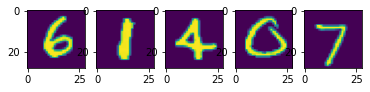

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')


Cream functii pentru train si test

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Salvam modelul 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306483
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.368935
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.135130
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.149327
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.118744
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.159381
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.120870

Test set: Average loss: 0.0690, Accuracy: (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.086085
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.055421
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.041307
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.081606
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.026036
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.069098
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.007368

Test set: Average loss: 0.0424, Accuracy: (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.014932
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.136826
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.024148
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.040639
Train Epoch: 3 [

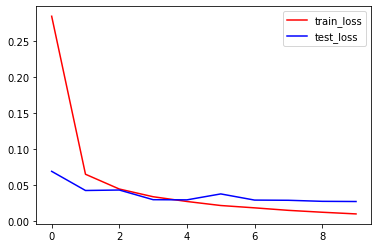

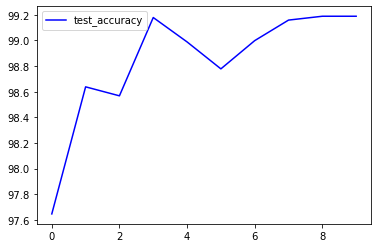

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist.pt")

Importam dataset-ul

In [ ]:
import pickle

def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  with open(path,'rb') as handle:
    data = pickle.load(handle)


  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_count = data['no_count'].astype(np.long)[:first_k]


  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_count = map(torch.tensor, 
                (np_dataset_large, np_dataset_count))
  dataset_large = dataset_large.to(device)
  dataset_count = dataset_count.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_count)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  return large_data_loader

path_train = '/content/gdrive/MyDrive/DL/mnist_count_train.pickle'
path_test = '/content/gdrive/MyDrive/DL/mnist_count_test.pickle'

large_data_loader_train_20 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_train_50 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=2500)
large_data_loader_train_100 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=5000)
large_data_loaders_train = [large_data_loader_train_20, large_data_loader_train_50, large_data_loader_train_100]

large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)

Modificam CNN ul sa fie full conv

In [ ]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        x = x.view(args.batch_size, 10, -1)
        return F.softmax(x, dim=2)
        #si val neg

Modificam modelul de mai devreme

In [ ]:
# data should be in [0,1]
def preprocess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# define the fully_conv model
model_fuly_conv = CNN_fully_conv()
PATH = 'mnist.pt'
# load classification model
loaded_state_dict = torch.load(PATH)

# loaded_state_dict contain the weights of the classification model
# For the fully_conv model we will use exactly the same parameters.
# For the convolutional part we can directly load them as they have the same name.

# We need to convert the last fully-connected layers into convolutions
# For a single neuron we would just reshape the parameters from a vector into a kernel. 
# We just need to know what is the spatial dimension of the original fully-connected input.
# In our case, the first fully-connected had an input of size 4 x 4 x no_filter2, so we must use kernels of size 4 x 4 x no_filter2
# The second fully-connected receives as input just a vector(1x1 spatial dimension) of size no_neurons1 thus we use kernels of size 1 x 1 x no_neurons1
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fuly_conv.load_state_dict(model_dict)
model_fuly_conv = model_fuly_conv.to(device)

print(model_fuly_conv.parameters)

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


In [ ]:
acc = 0
# mae = 0
for batch_idx, (large_imgs, target_counts) in enumerate(large_data_loader_test):
  prob = 0
  threshold = 0.85
  print(f'Batch id: {batch_idx}')
  large_imgs = preprocess(large_imgs)
  out_prob_maps = model_fuly_conv(large_imgs)

  max_ind = torch.sum(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0] >= threshold, dim = 1).float()
  prob = prob + max_ind
  acc = acc + torch.sum(prob == target_counts)/64

  # loss = torch.nn.L1Loss()
  # mae += loss(target_counts, prob)

acc = (acc / (batch_idx + 1) * 100)
# mae = mae / (batch_idx + 1)
print(acc)


Batch id: 0
Batch id: 1
Batch id: 2
Batch id: 3
Batch id: 4
Batch id: 5
Batch id: 6
Batch id: 7
Batch id: 8
Batch id: 9
Batch id: 10
Batch id: 11
Batch id: 12
Batch id: 13
Batch id: 14
tensor(26.7708, device='cuda:0')


In [ ]:
class CNN_2(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
      self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
      self.fully_conv2_new = nn.Conv2d(no_neurons1,10, 1)
      # add a linear layer 
      self.linear_loc = nn.Linear(19*19*10,5)


  def forward(self, xb):
      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)
      self.lin = self.linear_loc(self.conv_act)
      x = F.log_softmax(self.lin, dim=1)

      return x

In [ ]:
def train_new(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        data = preprocess(data)
        target = target.long() - 1
    
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()
 
def test_new(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.long() - 1
            data = preprocess(data)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

In [ ]:
def plot_acc(acc, data, label, color='blue'):
    pyplot.plot(acc, data, label=label, color=color)
    pyplot.legend()

In [ ]:
# save classification model
PATH = 'mnist.pt'
torch.save(model.state_dict(), PATH)
 
# we will train 2 models, one with random initialisation, 
# one with parameters initialised from the classification network
loc_model_scratch = CNN_2()
loc_model_pretrained = CNN_2()
 
# convert the fully-connected into convolutional layers
loaded_state_dict = torch.load(PATH)
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
 
 
loc_model_scratch = loc_model_scratch.to(device)
# load pretrained classification parameters into localisation model
loc_model_pretrained.load_state_dict(model_dict, strict=False)
loc_model_pretrained = loc_model_pretrained.to(device)
 
 
loc_model_pretrained.linear_loc.weight.data
 
optimizer_sgd_scratch = optim.SGD(
    loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)

optimizer_adam_scratch = optim.Adam(
    loc_model_scratch.parameters(), lr=0.001)

optimizer_adam_scratch_2 = optim.Adam(
    loc_model_scratch.parameters(), lr=0.001, weight_decay=1e-5)

optimizer_sgd_pretrained = optim.SGD(
    loc_model_pretrained.parameters(), lr=args.lr, momentum=args.momentum)

optimizer_adam_pretrained = optim.Adam(
    loc_model_pretrained.parameters(), lr=0.001)

optimizer_adam_pretrained_2 = optim.Adam(
    loc_model_pretrained.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)

optimizer_loc_scratch = [optimizer_sgd_scratch, optimizer_adam_scratch, optimizer_adam_scratch_2]

optimizer_loc_pretrained = [optimizer_sgd_pretrained, optimizer_adam_pretrained, optimizer_adam_pretrained_2]
 
acc_test = []
acc_test_pre = []
for i in large_data_loaders_train:
    print(f'For: {i}')

    losses_train = []
    losses_test = []

    for epoch in range(1, 10):
      
        # print(f'Scratch epoch: {epoch}')
        train_loss = train_new(args, loc_model_scratch, device, i, optimizer_loc_scratch[1], epoch)
        test_loss, test_acc  = test_new(args, loc_model_scratch, device, large_data_loader_test)
        
        losses_train.append(train_loss)
        losses_test.append(test_loss)
    acc_test.append(test_acc)

 
    losses_train_pre = []
    losses_test_pre = []


    for epoch in range(1, 10):
        # print(f'Pretrained epoch: {epoch}')
        train_loss = train_new(args, loc_model_pretrained, device, i, optimizer_loc_pretrained[1], epoch)
        test_loss, test_acc = test_new(args, loc_model_pretrained, device, large_data_loader_test)
                
        losses_train_pre.append(train_loss)
        losses_test_pre.append(test_loss)
    acc_test_pre.append(test_acc)
    
print("acc:", acc_test)
print("acc_pre:",acc_test_pre)

pyplot.figure(1)
plot_loss(losses_train,'scratch_train_loss','red')
plot_loss(losses_test,'scratch_test_loss')

    
plot_loss(losses_train_pre,'pretrained_train_loss','pink')
plot_loss(losses_test_pre,'pretrained_test_loss','green')

data = [1000, 2500, 5000]
pyplot.figure(2)
plot_acc(data,acc_test, 'test_accuracy_scratch','red')
plot_acc(data, acc_test_pre, 'test_accuracy_pretrained')

Am modificat lr din 0.01 in 0.001 ( am incercat mai multe dar acesta a fost cel mai bun )

Cu weight_decay=1e-5 si betas=(0.9, 0.999) am o acc de ~21 pe pretrained si 74.7 pe scratch, iar doar cu lr = 0.001 am  ~70 pe scratch si ~59 pe pretrained